# _Setup 
import needed packages

In [3]:
import os
import pandas as pd
import numpy as np
import random
import sys

import scipy
import sklearn

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix as skm_conf_mat
from sklearn.model_selection import train_test_split as skl_traintest_split
from sklearn.utils import shuffle

import sklearn.metrics as skm

import datetime as DT

Specify working dictionary 

In [4]:
projFld = "/Users/apple/Desktop/ADEC7430 Big Data Econometrics/Lecture08"
codeFld = os.path.join(projFld, "PyCode")
fnsFld = os.path.join(codeFld,"_Functions")
outputFld = os.path.join(projFld, "Output")
rawDataFld = os.path.join(projFld, "RawData")
savedDataFld = os.path.join(projFld, "SavedData")

import function packages

In [5]:
fnList = [
         "fn_logMyInfo"
        ,"fn_confusionMatrixInfo"
        ,"fn_MakeDummies"
        ,"fn_InfoFromTree"
        ] 
for fn in fnList:
    exec(open(os.path.join(fnsFld, fn + ".py")).read())

print(fn_MakeDummies.__doc__)


  dsin = dataset input
  varsToDummy = list of variable names which are to be transformed into dummies
  dsout = dataset output



# _Load and Prepare Data
import data

In [6]:
#Import Data
kdigits = pd.read_csv(os.path.join(rawDataFld, "KDigits_train.csv"))

In [7]:
kdigits.shape

(42000, 785)

In [8]:
kdigits.head() #784 pixels in 28x28 frame

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
kdigits.max()  #Pixel values cover full range 0-255

label         9
pixel0        0
pixel1        0
pixel2        0
pixel3        0
pixel4        0
pixel5        0
pixel6        0
pixel7        0
pixel8        0
pixel9        0
pixel10       0
pixel11       0
pixel12     116
pixel13     254
pixel14     216
pixel15       9
pixel16       0
pixel17       0
pixel18       0
pixel19       0
pixel20       0
pixel21       0
pixel22       0
pixel23       0
pixel24       0
pixel25       0
pixel26       0
pixel27       0
pixel28       0
           ... 
pixel754      0
pixel755      0
pixel756      0
pixel757      0
pixel758      0
pixel759      0
pixel760      0
pixel761    177
pixel762    231
pixel763    253
pixel764    254
pixel765    254
pixel766    255
pixel767    255
pixel768    255
pixel769    255
pixel770    255
pixel771    255
pixel772    255
pixel773    255
pixel774    254
pixel775    254
pixel776    253
pixel777    253
pixel778    254
pixel779     62
pixel780      0
pixel781      0
pixel782      0
pixel783      0
Length: 785, dtype: int6

In [10]:
train, test = skl_traintest_split(kdigits.copy(), test_size = 0.20, random_state = 2019)
train.shape

(33600, 785)

Scale data for 0/1 

In [11]:
def scale(data):
    X = data.drop(columns = {'label'})
    #Scale variance
    stdev = np.std(X, axis = 1)
    X_scaled = X.mul(1/stdev, axis = 0)
    #np.std(X_scaled, axis = 1) #Consistent variance across digits
    
    #Scale magnitude
    max_scale = X_scaled.max(axis=1) #Generate a vector of max values from each row
    X_scaled = X_scaled.mul(1/max_scale, axis=0) #Scale from 0-1 for each digit
    
    #np.std(X_train_scaled, axis = 1) # No longer consistet variance b/c we scaled the magnitude
    #This shows scaling variance does nothing b/c we also scaled magnitude. No difference in variance after magnitudes scaled
    #np.mean(np.std(X_train.mul(1/X_train.max(axis=1),axis =0),axis=1) - np.std(X_train_scaled, axis = 1))
    
    #Add labels back
    data = pd.concat([data['label'],X_scaled], axis = 1)
    return data

train = scale(train)
test = scale(test)

split Train/Test data for 50/50 bifurcation

In [12]:
def bifurcateDigits(whichSeries, value, train = True):
    temp = whichSeries.copy()
    if(value >= 10):
        print("Value's only range from 0-9")
        return
    #Boolean for label = value
    temp['label'] = (temp['label'] == value).astype(int)
    #Split T/F
    x1 = temp[temp['label'] == 1]
    x2 = temp[temp['label'] == 0]
    #Identify proportion of value to not value
    prop = len(x1)/len(x2)
    #Randomly select a subset of size prop from x2 (value = False)
    random.seed(2019)
    rndindex = [random.uniform(0,1) for x in range(x2.shape[0])]
    rndindex = [True if x < prop else False for x in rndindex]
    x2 = x2.loc[rndindex]
    #Shuffled subset of original with ~50/50 value to not value
    temp = shuffle(x1.append(x2))
    #Isolate dependent var from predictors for either train/test data
    if(train == False):
        global y_test, X_test
        y_test = temp['label']
        X_test = temp.drop(columns = {'label'})
    else:
        global y_train, X_train
        y_train = temp['label']
        X_train= temp.drop(columns = {'label'})

bifurcateDigits(train, 1, train = True)

View visual data

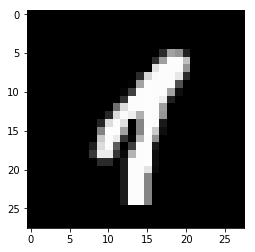

In [13]:
def viewDigits(whichSeries, threshold=None, dtype = 'float'):
    whichSeries = np.array(whichSeries, dtype=dtype)
    if threshold is not None:
        whichSeries = (whichSeries > threshold).astype(int)
    plt.imshow(whichSeries.reshape((28,28)), cmap='gray')

viewDigits(X_train.iloc[100])

In [15]:
print(y_train.value_counts())

0    3809
1    3801
Name: label, dtype: int64


In [16]:
bifurcateDigits(train, 1, train = False)
print(y_test.value_counts())

0    3809
1    3801
Name: label, dtype: int64


# Random Forest

AUC(digits 0-9)
[0.9986819154058043,
 0.9988793489425584,
 0.9938654160211046,
 0.991160197793199,
 0.9930134520651762,
 0.9924250960307299,
 0.9978484439498339,
 0.9972701508710511,
 0.9918733492740712,
 0.9853639556374396]

Accuracy(Digits 0-9)
[0.9855527638190955,
 0.9873780837636259,
 0.9686946249261665,
 0.9541809851088202,
 0.9635036496350365,
 0.9601567602873938,
 0.9798994974874372,
 0.9817324690630524,
 0.9564958283671037,
 0.9397590361445783]

# Gradient Boosting
import from sklearn and build the model

In [21]:
from sklearn.ensemble import GradientBoostingClassifier as GBClass
params = {'n_estimators':100, 'subsample':1.0, 'learning_rate':0.1}
params = dict(params)
model_gbc = GBClass(**params)

run models in loops to seperate each digit number 

In [43]:
bifurcateDigits(train, 0, train = True)   # when the digit is 0 
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3320,  489],
        [3800,    1]]),
 'accuracy': 0.4363994743758213,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8716198477290628,
 'specificity': 0.00026308866087871614}

RUC and AUC rate 

In [44]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.14890825112762396

In [22]:
bifurcateDigits(train, 1, train = True)   # when the digit is 1 
bifurcateDigits(test, 1, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3797,   12],
        [  13, 3788]]),
 'accuracy': 0.9967148488830486,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.9968495668154371,
 'specificity': 0.9965798474085766}

RUC and AUC rate 

In [25]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.9999691255890226

In [26]:
bifurcateDigits(train, 2, train = True)   # when the digit is 2 
bifurcateDigits(test, 2, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3331,  478],
        [3760,   41]]),
 'accuracy': 0.4431011826544021,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.874507744814912,
 'specificity': 0.01078663509602736}

RUC and AUC rate 

In [28]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.5759142710852024

In [29]:
bifurcateDigits(train, 3, train = True)   # when the digit is 3 
bifurcateDigits(test, 3, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3238,  571],
        [3756,   45]]),
 'accuracy': 0.4314060446780552,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8500918876345498,
 'specificity': 0.011838989739542225}

RUC and AUC rate 

In [30]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.4928053988638907

In [31]:
bifurcateDigits(train, 4, train = True)   # when the digit is 4 
bifurcateDigits(test, 4, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3318,  491],
        [3788,   13]]),
 'accuracy': 0.43771353482260184,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8710947755316356,
 'specificity': 0.0034201525914233097}

RUC and AUC rate 

In [32]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.46413978607141354

In [33]:
bifurcateDigits(train, 5, train = True)   # when the digit is 5 
bifurcateDigits(test, 5, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3290,  519],
        [3779,   22]]),
 'accuracy': 0.4352168199737188,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8637437647676556,
 'specificity': 0.005787950539331755}

RUC and AUC rate 

In [34]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.39328598289999683

In [35]:
bifurcateDigits(train, 6, train = True)   # when the digit is 6 
bifurcateDigits(test, 6, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3339,  470],
        [3775,   26]]),
 'accuracy': 0.44218134034165574,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8766080336046206,
 'specificity': 0.0068403051828466194}

RUC and AUC rate 

In [36]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.4862796396935518

In [37]:
bifurcateDigits(train, 7, train = True)   # when the digit is 7 
bifurcateDigits(test, 7, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3283,  526],
        [3777,   24]]),
 'accuracy': 0.4345597897503285,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8619060120766605,
 'specificity': 0.006314127861089187}

RUC and AUC rate 

In [38]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.5655071771263577

In [39]:
bifurcateDigits(train, 8, train = True)   # when the digit is 8 
bifurcateDigits(test, 8, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3294,  515],
        [3706,   95]]),
 'accuracy': 0.445335085413929,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8647939091625099,
 'specificity': 0.024993422783478034}

RUC and AUC rate 

In [40]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.489022696421863

In [41]:
bifurcateDigits(train, 9, train = True)   # when the digit is 9 
bifurcateDigits(test, 9, train = False)
model_gbc.fit(X_train, y_train)
pred_Y = model_gbc.predict(X_test)
z_gbc = model_gbc.predict_proba(X_test)[:,1]

confusionMatrixInfo(pred_Y, y_test, labels = None)

{'confusionMatrix': array([[3230,  579],
        [3793,    8]]),
 'accuracy': 0.4254927726675427,
 'no information rate': 0.5005256241787123,
 'sensitivity': 0.8479915988448412,
 'specificity': 0.002104709287029729}

RUC and AUC rate 

In [42]:
fpr_gbc, tpr_gbc, thresh_gbc = skm.roc_curve(y_test, z_gbc)
# plt.figure(1)
# plt.plot(fpr_gbc, tpr_gbc, 'r-')

# AUC 
skm.auc(fpr_gbc,tpr_gbc)

0.32551292101006435

Accuracy Table 

Accuracy(Digits 0-9)
0.4363994743758213
0.9967148488830486
0.4431011826544021
0.4314060446780552
0.43771353482260184
0.4352168199737188
0.44218134034165574
0.4254927726675427

# Neural Network 

Example of feedforward 

In [5]:
import numpy as np

def sigmoid(x):
  # Our activation function: f(x) = 1 / (1 + e^(-x))
  return 1 / (1 + np.exp(-x))

class Neuron:
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias

    def feedforward(self, inputs):
        # Weight inputs, add bias, then use the activation function
        total = np.dot(self.weights, inputs) + self.bias
        return sigmoid(total)

In [6]:
weights = np.array([0, 1]) 
bias = 4                
n = Neuron(weights, bias)

In [7]:
x = np.array([2, 3])    
print(n.feedforward(x)) 

0.9990889488055994


In [8]:
class OurNeuralNetwork:
  '''
  A neural network with:
    - 2 inputs
    - a hidden layer with 2 neurons (h1, h2)
    - an output layer with 1 neuron (o1)
  Each neuron has the same weights and bias:
    - w = [0, 1]
    - b = 0
  '''
    def __init__(self):
        weights = np.array([0, 1])
        bias = 0

        # The Neuron class here is from the previous section
        self.h1 = Neuron(weights, bias)
        self.h2 = Neuron(weights, bias)
        self.o1 = Neuron(weights, bias)

    def feedforward(self, x):
        out_h1 = self.h1.feedforward(x)
        out_h2 = self.h2.feedforward(x)

        # The inputs for o1 are the outputs from h1 and h2
        out_o1 = self.o1.feedforward(np.array([out_h1, out_h2]))

        return out_o1

In [9]:
network = OurNeuralNetwork()
x = np.array([2, 3])
print(network.feedforward(x))

0.7216325609518421


# introducing CNN and PNN 